<a href="https://colab.research.google.com/github/cj-mclaughlin/CS549_MaskDetection/blob/main/Face_Mask_YOLO_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code based on this colab notebook tutorial: https://colab.research.google.com/drive/1gDZ2xcTOgR39tGGs-EZ6i3RTs16wmzZQ
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies
%cd /content/yolov5

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 10208, done.
remote: Total 10208 (delta 0), reused 0 (delta 0), pack-reused 10208
Receiving objects: 100% (10208/10208), 10.53 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (7050/7050), done.
     |████████████████████████████████| 11.2 MB 9.0 MB/s 
     |████████████████████████████████| 15.7 MB 46.2 MB/s 
     |████████████████████████████████| 60.3 MB 1.5 MB/s 
     |████████████████████████████████| 3.1 MB 66.7 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
     |████████████████████████████████| 62 kB 941 kB/s 
     |████████████████████████████████| 38.1 MB 11.3 MB/s 
     |████████████████████████████████| 11.3 MB 50.6 MB/s 
     |████████████████████████████████| 884 kB 54.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: Pillow
    Found existing install

/content/yolov5


In [7]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
# Export code snippet and paste here
%cd /content
!curl -L "https://app.roboflow.com/ds/ufF0wzmULJ?key=Fxeda1HEqN" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [4]:
# import image utilities
from PIL import Image

# import os utilities
import os

# define a function that rotates images in the current directory
# given the rotation in degrees as a parameter
def rotateImages(rotationAmt):
  # for each image in the current directory
  for image in os.listdir(os.getcwd()):
    # open the image
    img = Image.open(image)
    # rotate and save the image with the same filename
    img.rotate(rotationAmt).save(image)
    # close the image
    img.close()


In [5]:
# This is just for rotating images if needed
%cd /content/drive/MyDrive/visionpictures
rotateImages(270)

/content/drive/.shortcut-targets-by-id/12ygTRiO5eKGUw35HlObvO6tN0Ho2FjNh/visionpictures


In [5]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['mask_weared_incorrect', 'with_mask', 'without_mask']

In [6]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [8]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

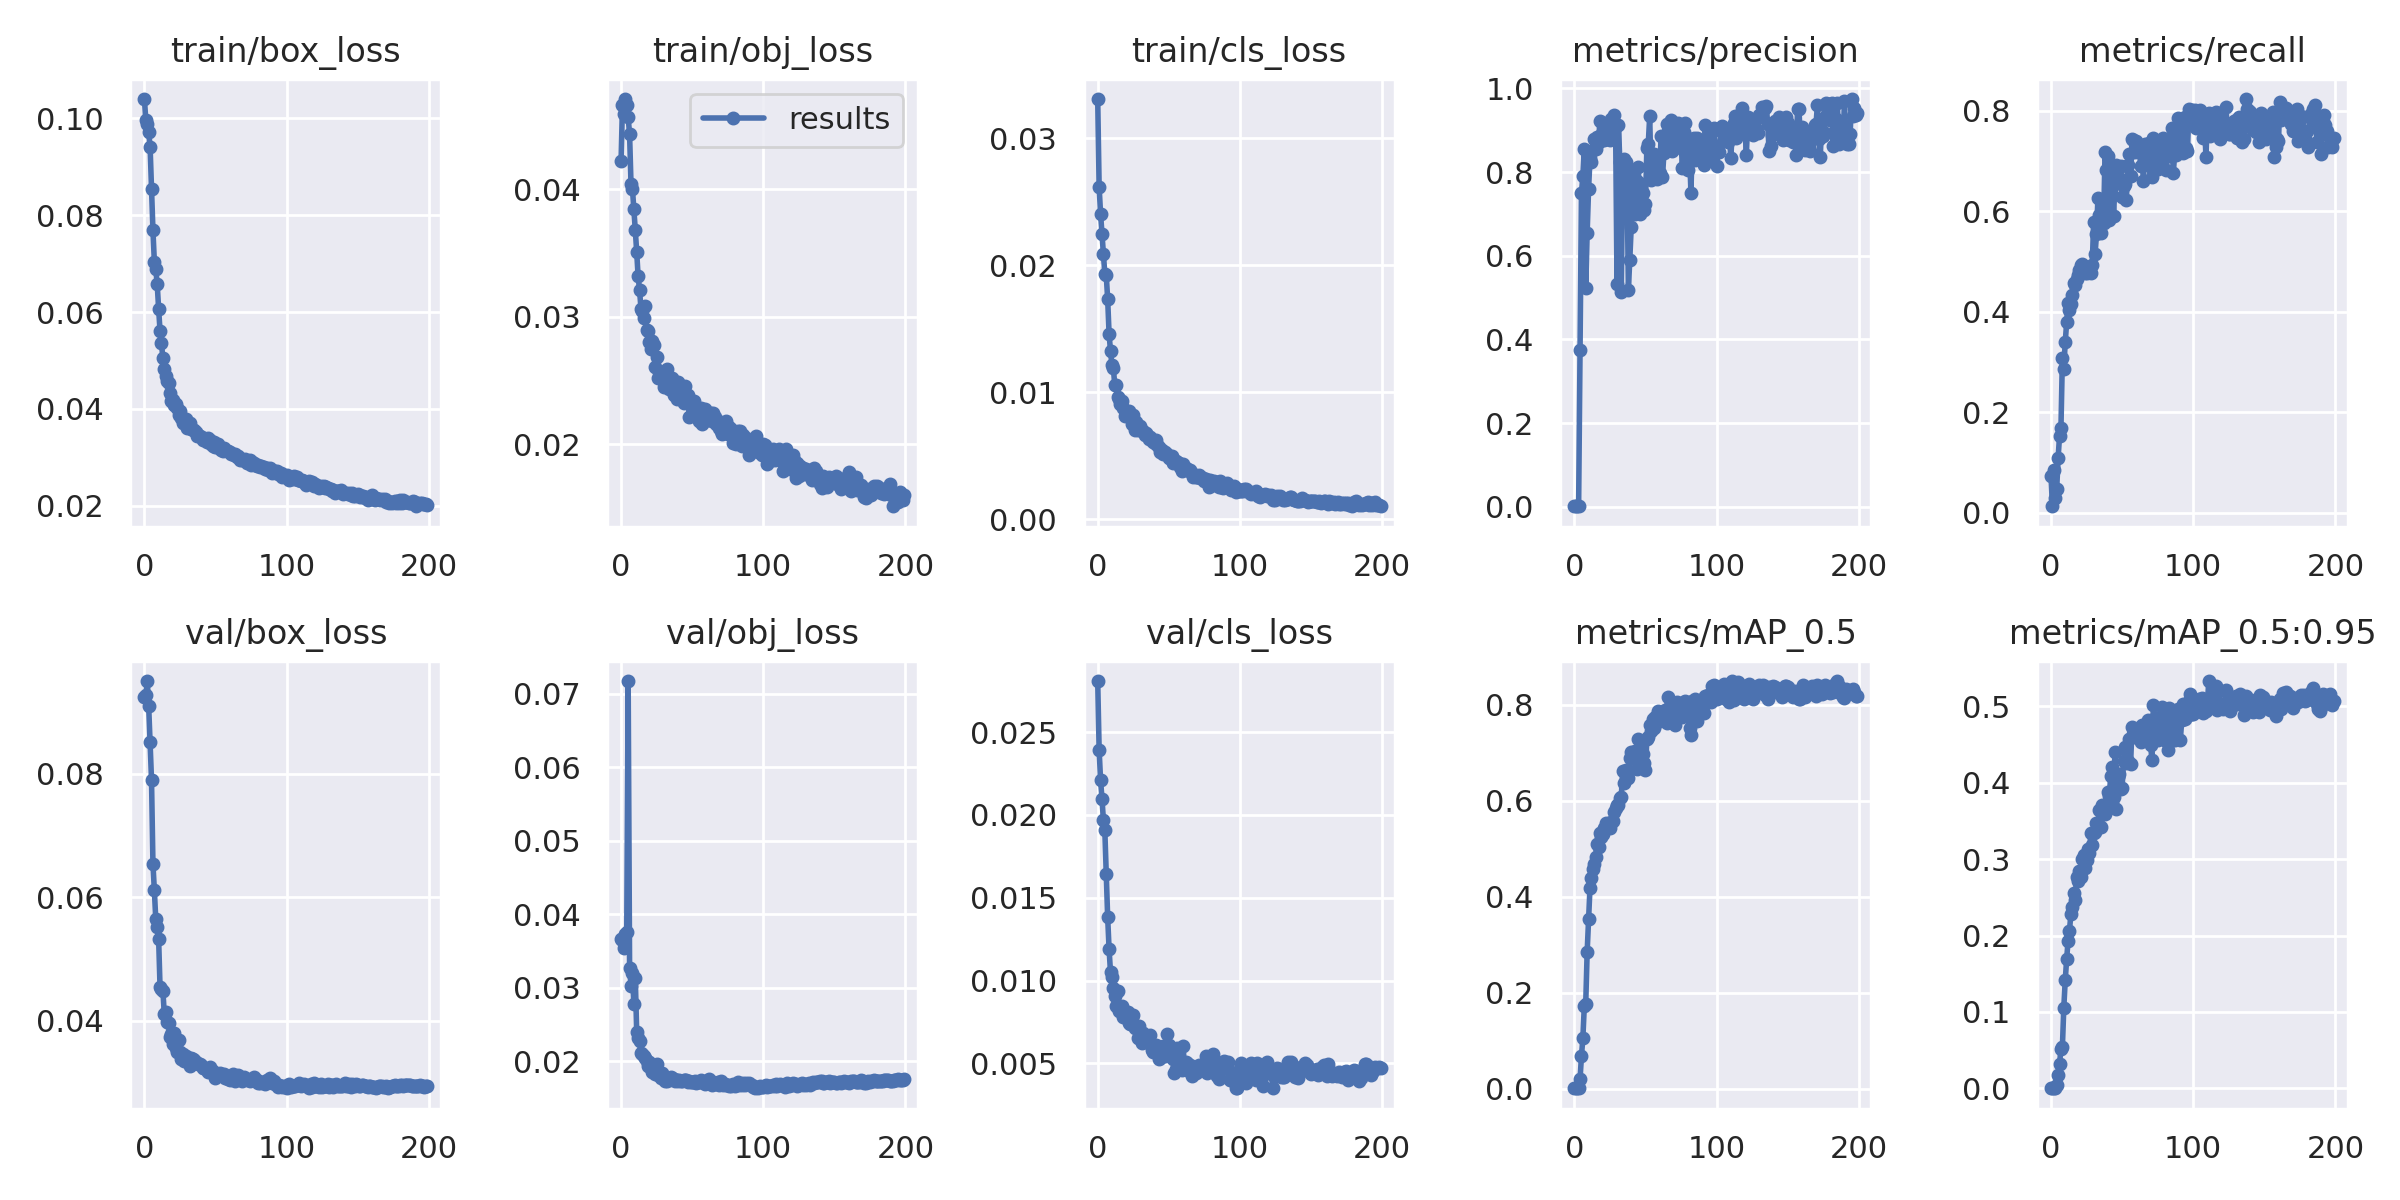

In [17]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


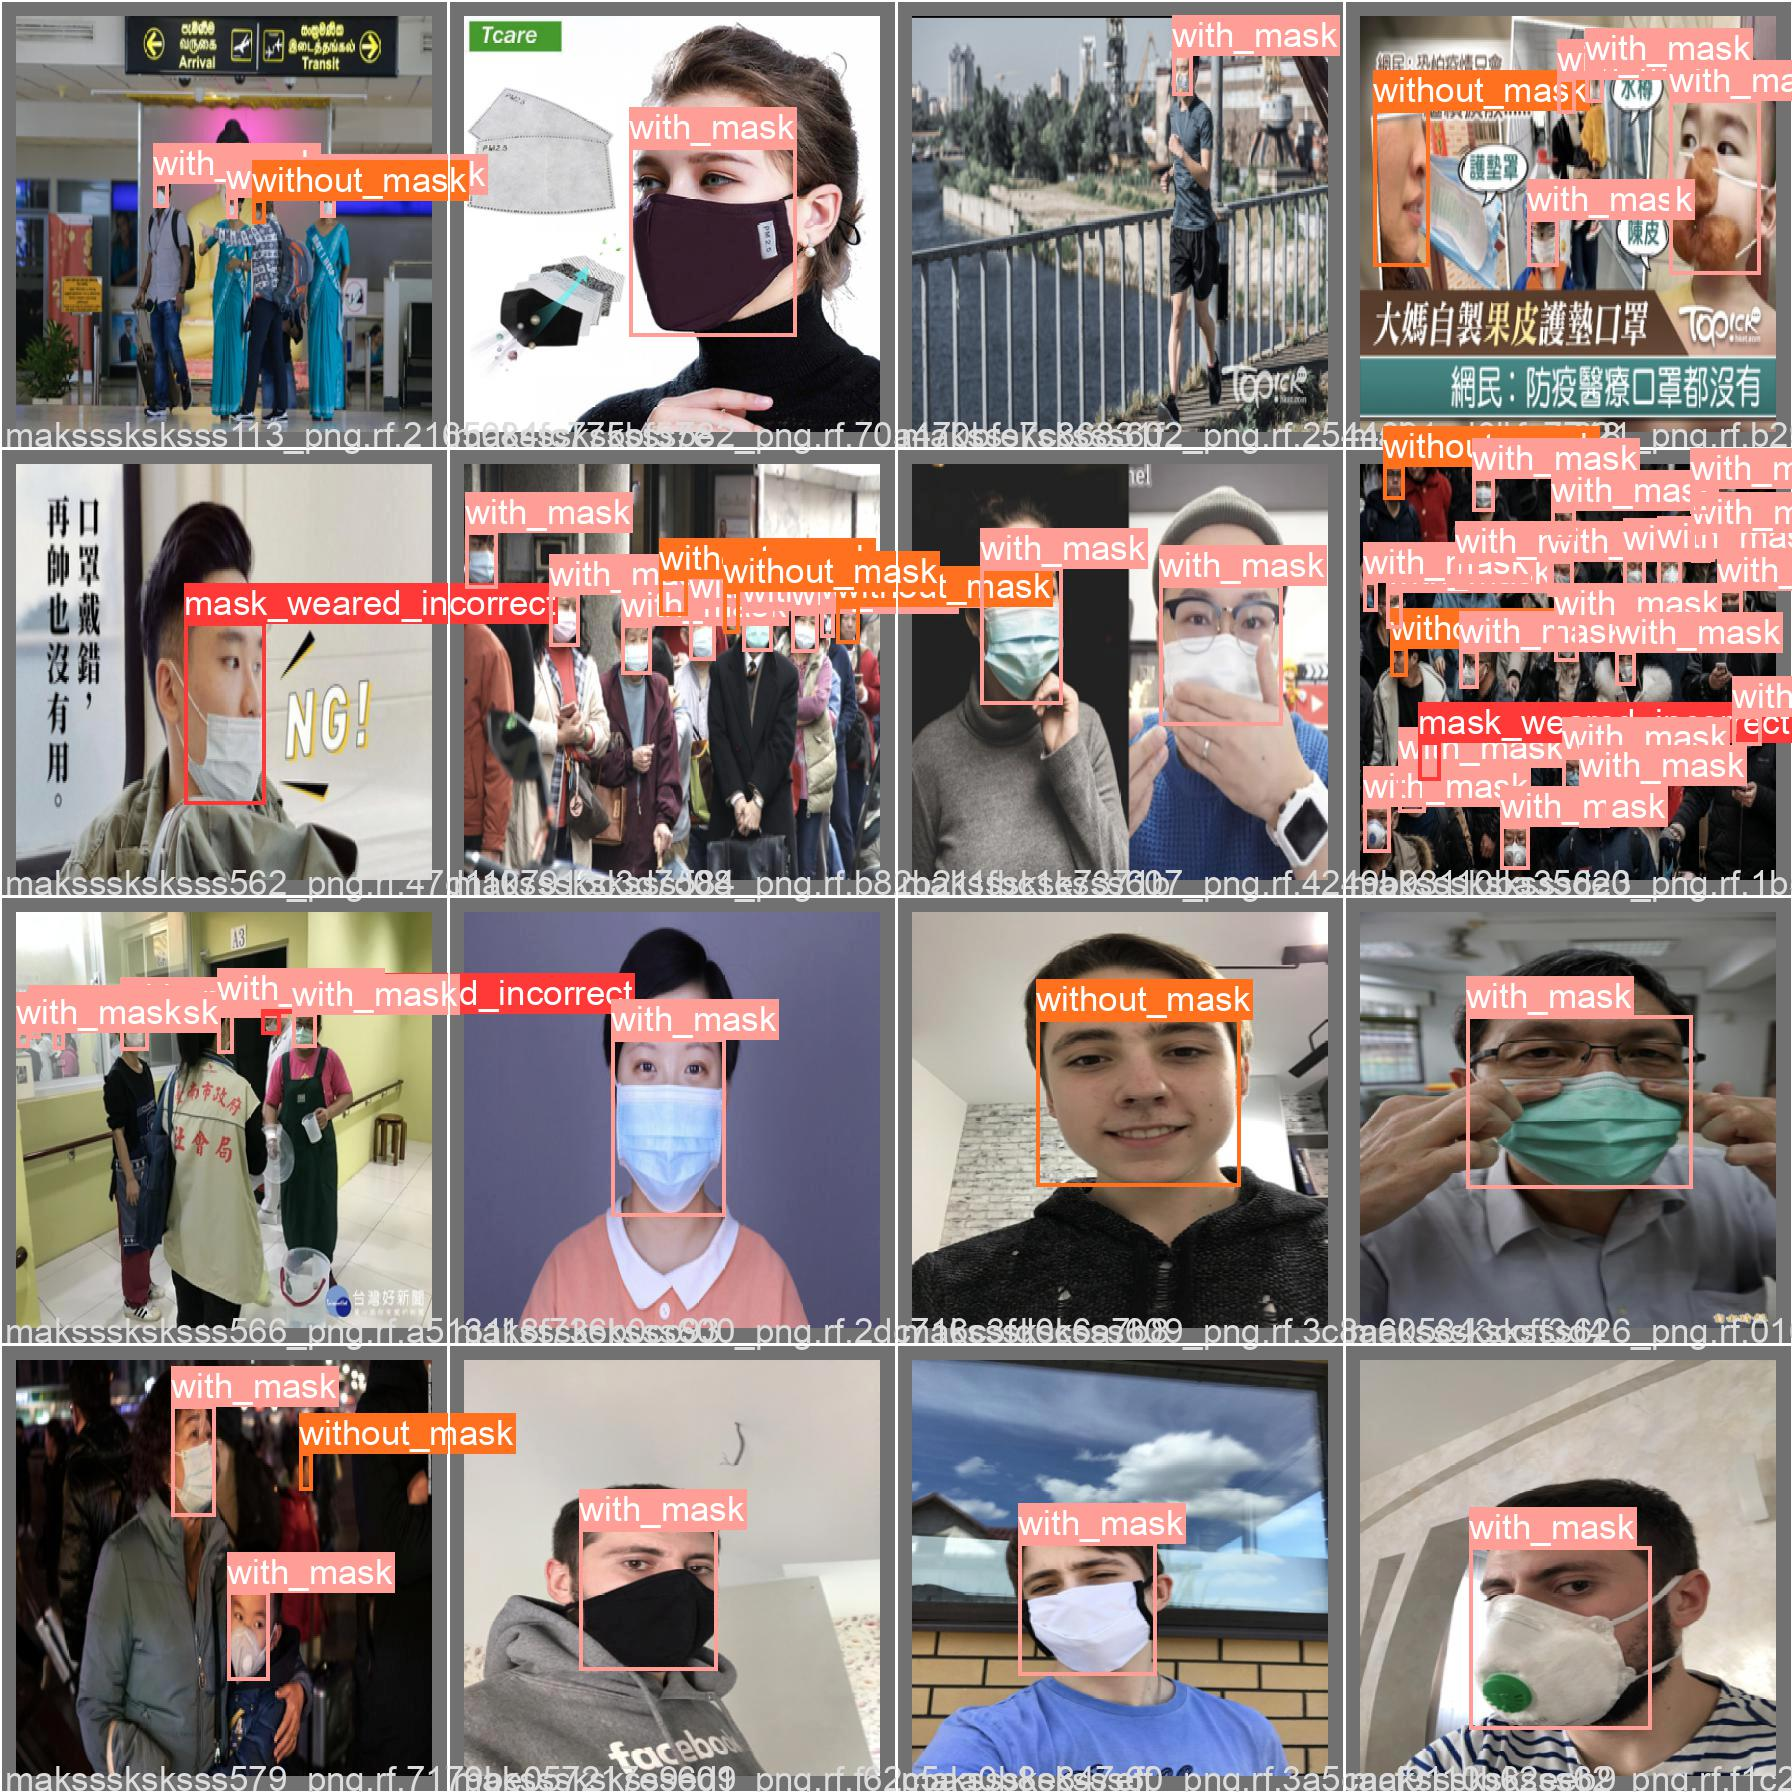

In [18]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


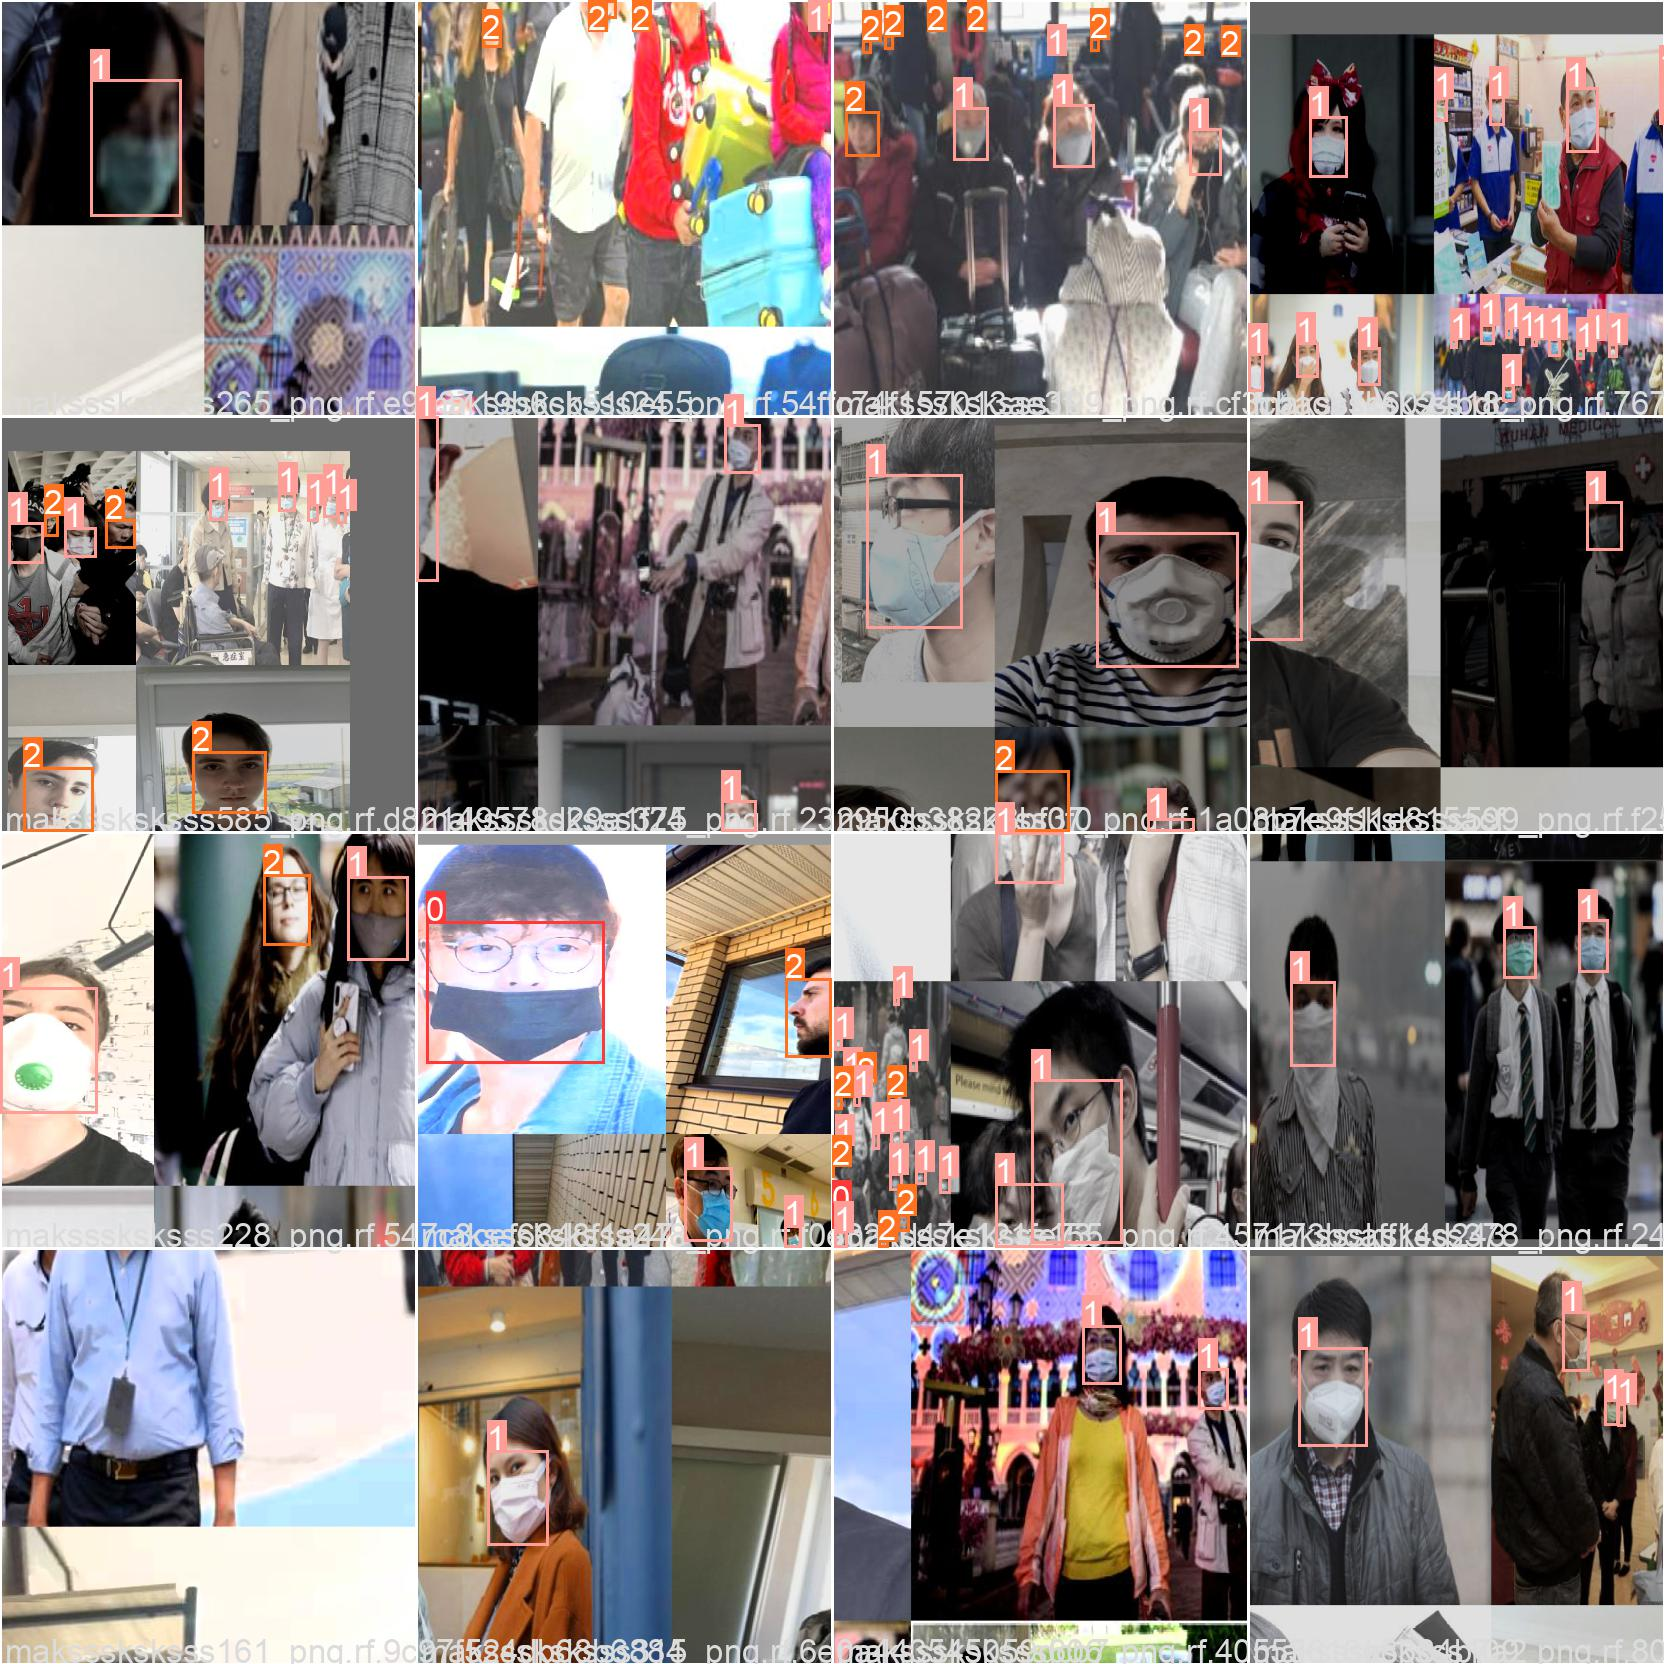

In [19]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

CONFUSION MATRIX:


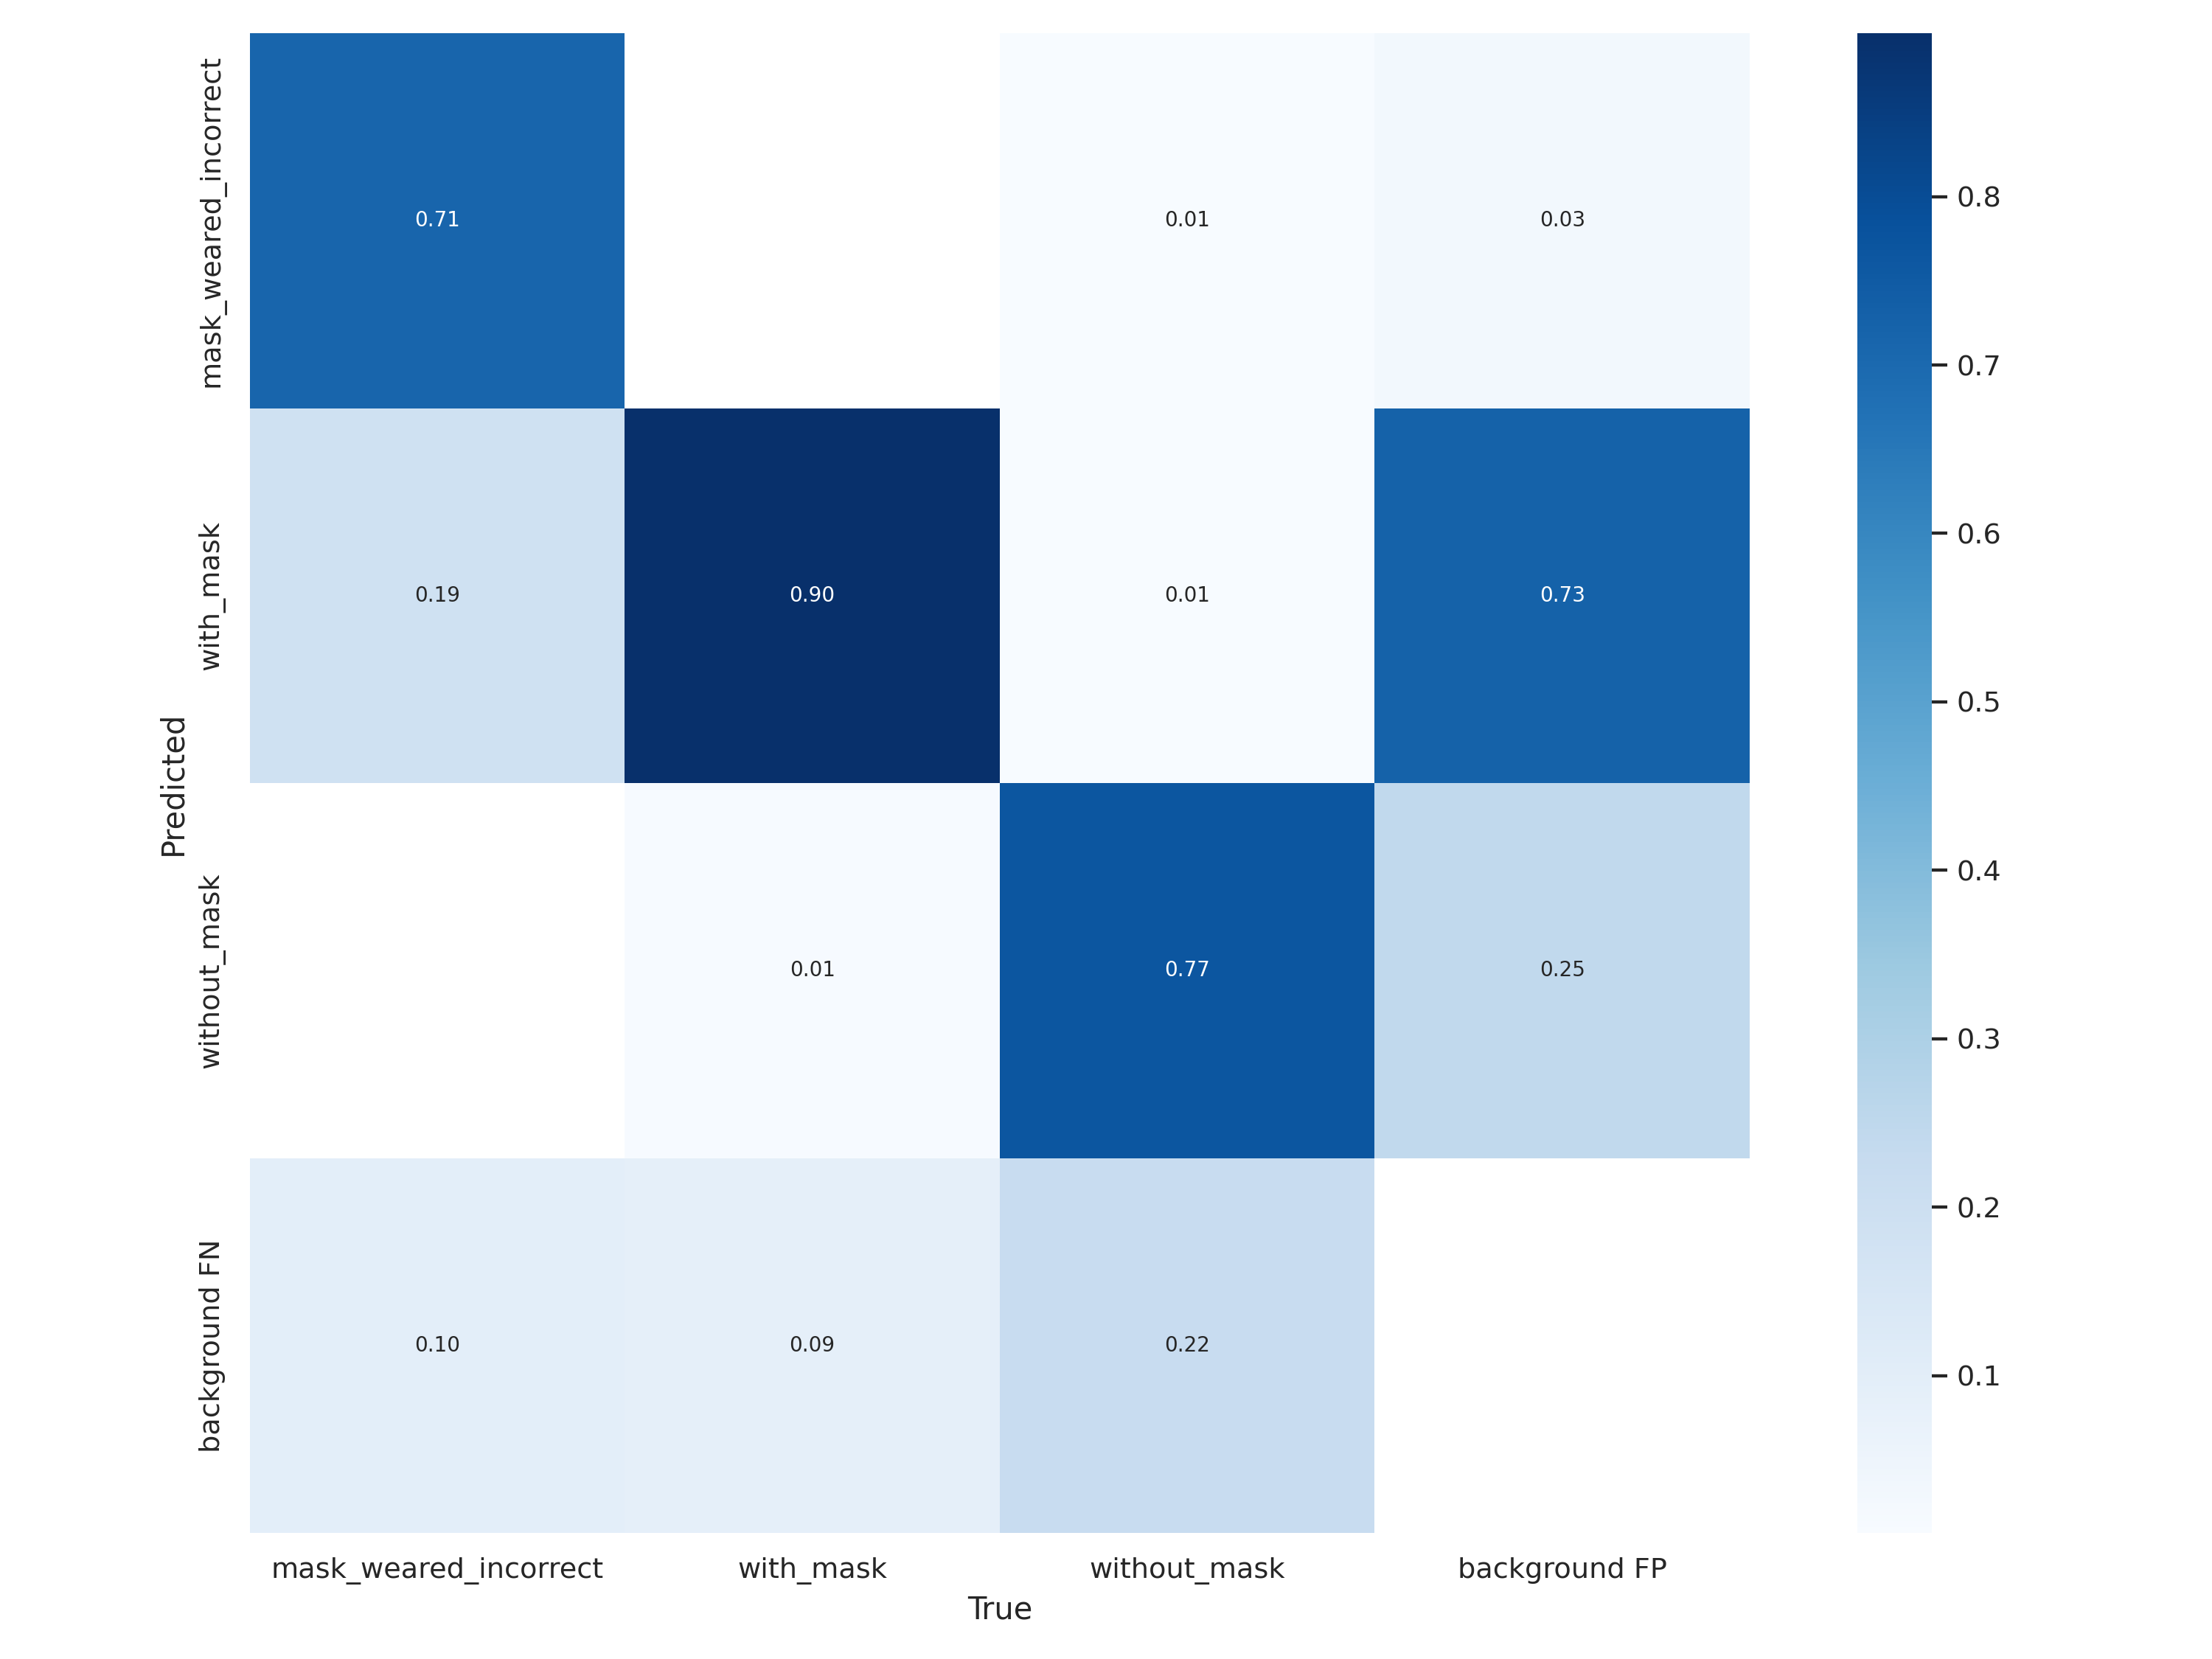

In [20]:
# print out an augmented training example
print("CONFUSION MATRIX:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/confusion_matrix.png', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


In [15]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python val.py --weights runs/train/yolov5s_results/weights/best.pt --name yolov5s_test_results --img 416 --conf 0.4 --data '../data.yaml'

/content/yolov5
val: data=../data.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.4, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolov5s_test_results, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-144-gc9a46a6 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
val: Scanning '../test/labels.cache' images and labels... 128 found, 0 missing, 0 empty, 0 corrupted: 100% 128/128 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 4/4 [00:07<00:00,  1.89s/it]
                 all        128        651      0.937      0.662      0.806      0.576
mask_weared_incorrect        128         16      0.912        0.5      0.697      0.547
           

TEST CONFUSION MATRIX:


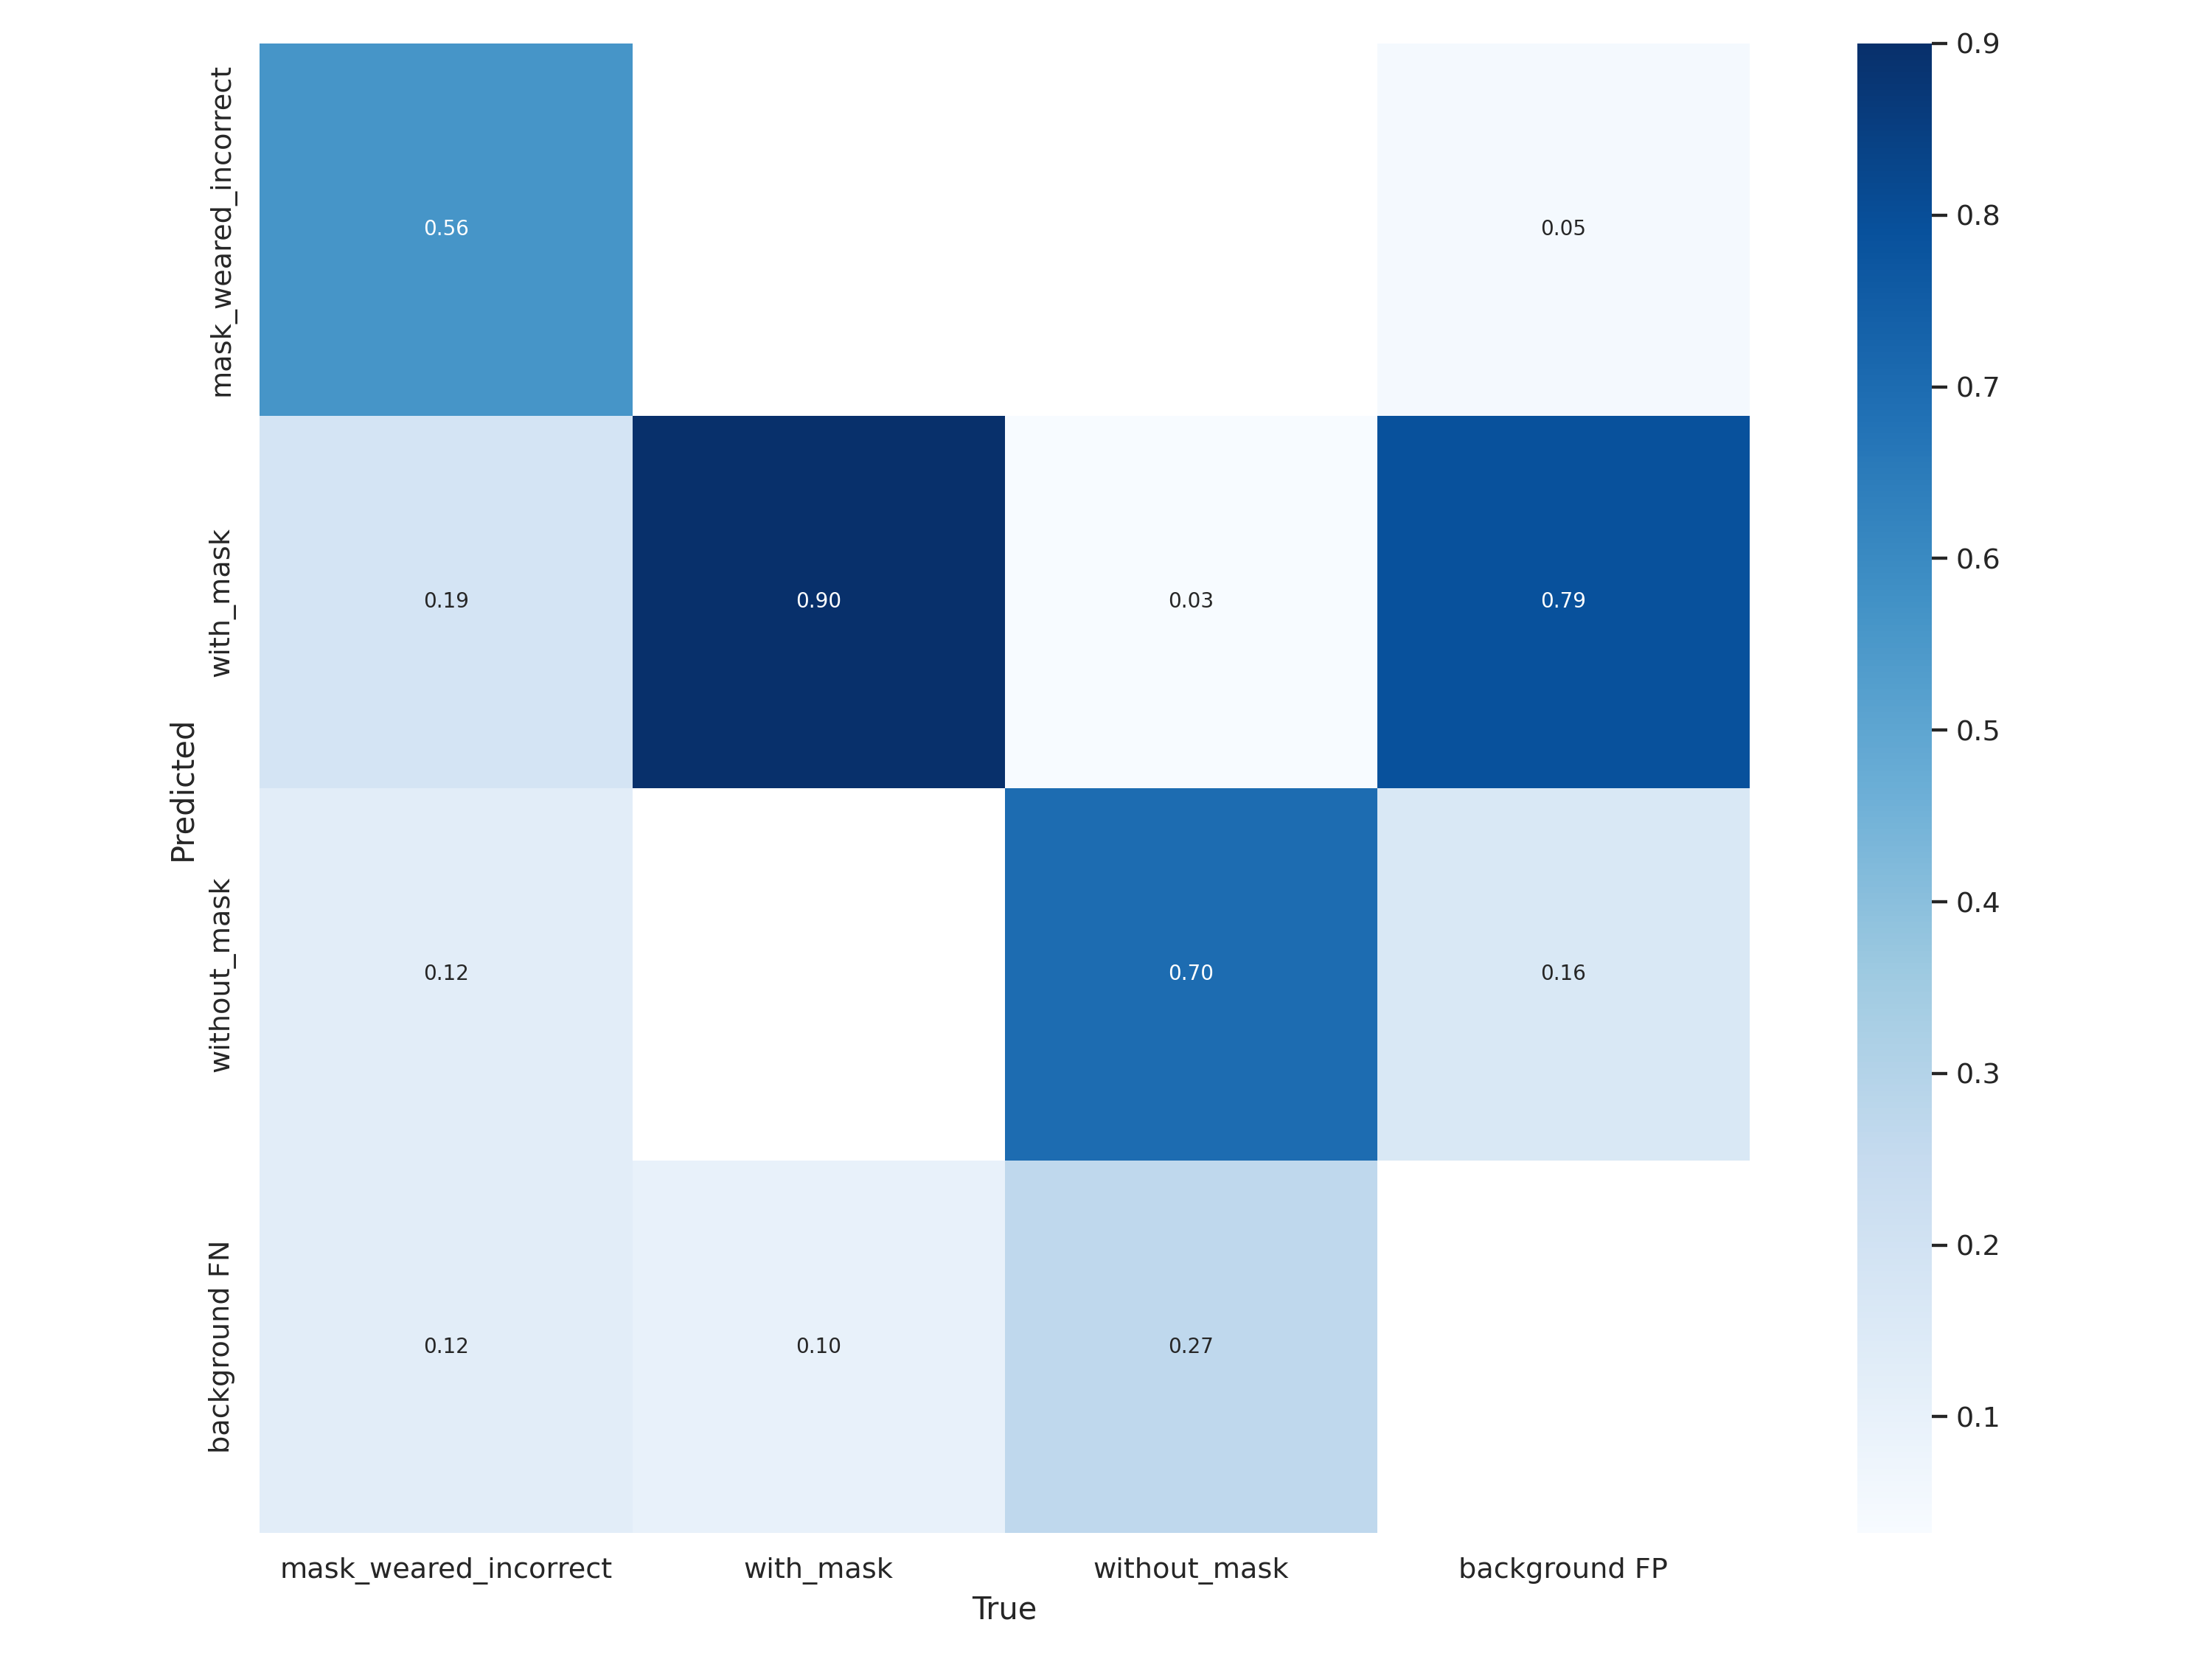

In [16]:
# print out an augmented training example
print("TEST CONFUSION MATRIX:")
Image(filename='/content/yolov5/runs/val/yolov5s_test_results/confusion_matrix.png', width=900)

In [10]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights ../best_aug.pt --name yolov5s_test_results --img 416 --conf 0.4 --source ../test16/ --hide-labels --hide-conf

/content/yolov5
detect: weights=['../best_aug.pt'], source=../test16/, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5s_test_results, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=True, half=False, dnn=False
YOLOv5 🚀 v6.0-144-gc9a46a6 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
image 1/16 /content/test16/maksssksksss834_png.rf.d0ac235f6a46d9a9c52c5f135737849b.jpg: 416x416 4 with_masks, 1 without_mask, Done. (0.007s)
image 2/16 /content/test16/maksssksksss835_png.rf.3fd38a257898e995b710b8144954ade3.jpg: 416x416 1 mask_weared_incorrect, 1 with_mask, Done. (0.007s)
image 3/16 /content/test16/maksssksksss84_png.rf.577165c13bb6b0a621c2f70a518b86b2.jpg: 416x

In [11]:
# Zip model
!zip -r /content/yolov5.zip /content/yolov5

  adding: content/yolov5/runs/detect/ (stored 0%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/ (stored 0%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss850_png.rf.d84d9a399ddcb7d8907ae93e9f4d819d.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss851_png.rf.c26ec4c1f461476dd82d8b628ecf048e.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss89_png.rf.0604506269834cbcbcab5d6c711edde0.jpg (deflated 3%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss97_png.rf.25ceecc688140d1701b3ff7e77e6ae38.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss96_png.rf.00e4291201bebf9e337f597a9ba640dd.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss835_png.rf.3fd38a257898e995b710b8144954ade3.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/yolov5s_test_results/maksssksksss84_png.rf.577165c13b

In [ ]:
# Download model
from google.colab import files
files.download("/content/yolov5.zip")